### Strength of schedule estimation usage of `turf`

---

This notebook demonstrates how to estimate a team's strength of schedule as the winning percentage of the median team if it were to play the given team's schedule.

David Fleming, 2023

In [1]:
import numpy as np
import pymc as pm
import arviz as az
from turf import scrape, utils, inference

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

**Initiate and fit model**

---


In [2]:
# Pull season results to-date
season = scrape.Season(year=2023, week=None)

/Users/davidfleming/turf/turf/scrape.py:133: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_html(url, parse_dates=True, attrs={'id': 'games'},


In [3]:
# Initialize model
model = inference.CorrelatedPoisson(season)

In [4]:
# Run inference on 4 cores (1 chain per core)
model.run_inference(tune=1000, draws=1000, target_accept=0.9, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, intercept, chol_cov, atts_defs_star]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [5]:
# Examine MCMC statistics to check convergence
az.summary(model.trace_, group='posterior', var_names=['att'], filter_vars='like')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"atts_defs_star[ARZ, att]",-0.167,0.087,-0.321,0.006,0.002,0.001,3198.0,3043.0,1.0
"atts_defs_star[ARZ, def]",0.169,0.070,0.041,0.308,0.001,0.001,4312.0,3103.0,1.0
"atts_defs_star[ATL, att]",-0.142,0.084,-0.309,0.007,0.001,0.001,3708.0,3003.0,1.0
"atts_defs_star[ATL, def]",0.008,0.075,-0.140,0.144,0.001,0.001,4147.0,3028.0,1.0
"atts_defs_star[BLT, att]",0.221,0.075,0.069,0.352,0.001,0.001,2885.0,3121.0,1.0
...,...,...,...,...,...,...,...,...,...
atts[SEA],0.021,0.073,-0.111,0.163,0.001,0.001,7460.0,3072.0,1.0
atts[SF],0.251,0.066,0.125,0.372,0.001,0.001,6930.0,3109.0,1.0
atts[TB],-0.070,0.074,-0.204,0.072,0.001,0.001,9068.0,3164.0,1.0
atts[TEN],-0.052,0.076,-0.201,0.084,0.001,0.001,8894.0,2998.0,1.0


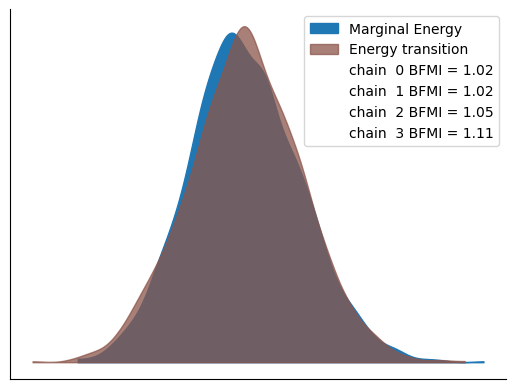

In [6]:
# Same as above, but visualizing energy of chain transition
# Should be ~1 for good convergence
ax = az.plot_energy(model.trace_)
sns.despine(ax=ax)

**Estimate strength of schedule**

---

Simulate NFL results to estimate a team's strength of schedule as the win percentage of the median team playing the same schedule.

In [7]:
# Check out the function for estimating the strength of schedule
model.sos??

Signature: model.sos(n: int = 100) -> numpy.ndarray
Source:   
    def sos(self, n : int=100) -> Union[np.ndarray, np.ndarray]:
        """
        Simulate NFL results to estimate a team's strength of schedule 
        as the win percentage of the median team playing the same schedule.

        Parameters
        ----------
        n : int (optional)
            Number of times to simulate each game. Defaults to 100.

        Returns
        -------
        sos : np.ndarray
            Strength of schedule for teams in team_names
        team_names : np.ndarray
            Array of team names aligned with SOS
        """

        # Assert model is fit with new util fn
        assert ut.check_model_inference(self.model), "model must be ran via model.run_inference() prior to simulations"

        # Extract team names from trace
        team_names = self.trace_.posterior.coords['teams'].values
        sos = np.zeros(len(team_names))

        # Simulate winning percentage of median team f

In [8]:
# Estimate strength of schedule
sos, team_names = model.sos(n=250)

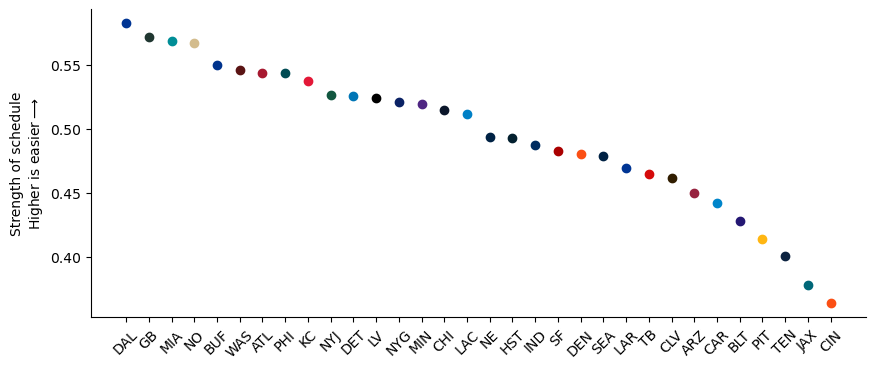

In [9]:
# Plot ordered strength of schedule
fig, ax = plt.subplots(figsize=(10,4))

# Order values by easiest to most difficult schedule
inds = np.argsort(sos)[::-1]
pri_colors = list(map(lambda x : utils._hex_color[f"{x}_0"], team_names))

x = np.arange(len(sos))
for ii in range(len(x)):
    ax.scatter(x[ii], sos[inds[ii]], color=pri_colors[inds[ii]])

ax.set_xlabel('')
ax.set_ylabel('Strength of schedule\nHigher is easier$\longrightarrow$')
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(model._coords["teams"][inds], rotation=45)
sns.despine(ax=ax)